## 必要なプログラムパッケージのインストール

まず、Pythonにpyscf, qulacs, openfermion, openfermion-pyscfをインストールする。(qulacsのインストールにはgcc7以上が必要。)
```
pip install pyscf openfermion
pip install openfermionpyscf
pip install qulacs
```

その後JuliaやPyCall.jlの導入。。。。
この他にもscipyやmatplotlibをこのノートでは使用している。

In [1]:
import Revise

In [2]:
import QCMaterial: uccsd1, convert_openfermion_op

In [3]:
using PyCall

In [4]:
plt = pyimport("matplotlib.pyplot")
of = pyimport("openfermion")
ofpyscf = pyimport("openfermionpyscf")
qulacs = pyimport("qulacs")
scipy_opt = pyimport("scipy.optimize")

get_fermion_operator = of.transforms.get_fermion_operator
jordan_wigner = of.transforms.jordan_wigner

PyObject <function jordan_wigner at 0x14e44d1bf790>

## Openfermion-PySCFの基本的な使い方
OpenFermionとPySCF（とそのインターフェイスであるOpenfermion-PySCF）を用いて、水素分子のハミルトニアンを用意し、スピン系にマッピングする。
ここではJordan-Wigner展開を用いることとする。

In [5]:
# 分子と古典計算のセットアップ
basis = "STO-3G" #原子軌道基底関数系の指定。STO-3Gは化学的に許される「最小」基底の一つ。
multiplicity = 1 #分子の多重度（２S+1）。多くの安定な有機分子はシングレット（S=0）。
charge = 0 #分子の賞味の電荷（原子核の電荷の和と全電子数の差分）。通常ゼロ。
distance  = 1.4 #ここではH2のHとHの距離を指定するのに用いている。確か単位はオングストローム（要確認）
geometry = [["H", [0,0,0]],["H", [0,0,distance]]] #分子の指定。各原子の元素とその原子のデカルト座標での位置。
molecule = of.MolecularData(geometry, basis, multiplicity, charge, data_directory=@__DIR__) #MolecularDataはopenfermionのクラス。data_directoryはdataを保存する場所を示す。
molecule = ofpyscf.run_pyscf(molecule,run_scf=1,run_fci=1) #PySCF計算の実行。run_scf=1はHartree-Fockの実行を意味し、run_fci=1は厳密対角化の実施を意味する。第二量子化表現を得るにはrun_scfは必須
n_qubit = molecule.n_qubits #Qubit数の取得。
n_electron = molecule.n_electrons #電子数の情報の取得
#第二量子化表現のフェルミオンのハミルトニアンを得る
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
#JW変換
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

PyObject (-0.4738003159609355+0j) [] +
(-0.05575552226867874+0j) [X0 X1 Y2 Y3] +
(0.05575552226867874+0j) [X0 Y1 Y2 X3] +
(0.05575552226867874+0j) [Y0 X1 X2 Y3] +
(-0.05575552226867874+0j) [Y0 Y1 X2 X3] +
(0.10053557435398454+0j) [Z0] +
(0.14120468151365048+0j) [Z0 Z1] +
(0.08678749878785741+0j) [Z0 Z2] +
(0.14254302105653616+0j) [Z0 Z3] +
(0.10053557435398452+0j) [Z1] +
(0.14254302105653616+0j) [Z1 Z2] +
(0.08678749878785741+0j) [Z1 Z3] +
(-0.04903236441486043+0j) [Z2] +
(0.14891189696596438+0j) [Z2 Z3] +
(-0.04903236441486044+0j) [Z3]

In [15]:
molecule.get_molecular_hamiltonian()

PyObject () 0.37798372208571435
((0, 1), (0, 0)) -0.9421415514240572
((1, 1), (1, 0)) -0.9421415514240572
((2, 1), (2, 0)) -0.658420104790995
((3, 1), (3, 0)) -0.658420104790995
((0, 1), (0, 1), (0, 0), (0, 0)) 0.28240936302730096
((0, 1), (0, 1), (2, 0), (2, 0)) 0.11151104453735747
((0, 1), (1, 1), (1, 0), (0, 0)) 0.28240936302730096
((0, 1), (1, 1), (3, 0), (2, 0)) 0.11151104453735747
((0, 1), (2, 1), (0, 0), (2, 0)) 0.11151104453735747
((0, 1), (2, 1), (2, 0), (0, 0)) 0.28508604211307237
((0, 1), (3, 1), (1, 0), (2, 0)) 0.11151104453735747
((0, 1), (3, 1), (3, 0), (0, 0)) 0.28508604211307237
((1, 1), (0, 1), (0, 0), (1, 0)) 0.28240936302730096
((1, 1), (0, 1), (2, 0), (3, 0)) 0.11151104453735747
((1, 1), (1, 1), (1, 0), (1, 0)) 0.28240936302730096
((1, 1), (1, 1), (3, 0), (3, 0)) 0.11151104453735747
((1, 1), (2, 1), (0, 0), (3, 0)) 0.11151104453735747
((1, 1), (2, 1), (2, 0), (1, 0)) 0.28508604211307237
((1, 1), (3, 1), (1, 0), (3, 0)) 0.11151104453735747
((1, 1), (3, 1), (3, 0), (1

## Qulacsを用いた分子計算の準備
まず、OpenFermionを用いて得たハミルトニアン(jw_hamiltonian)をQulacsで使えるようにする。

In [6]:
#Qulacs用のハミルトニアンの作成
qulacs_hamiltonian = qulacs.observable.create_observable_from_openfermion_text(jw_hamiltonian.__str__())

PyObject <qulacs.Observable object at 0x14e4289e17f0>

In [7]:
hfstate(n_qubit, n_electron) = parse(Int, repeat("0", n_qubit-n_electron) * repeat("1", n_electron), base=2)

hfstate (generic function with 1 method)

Hartree-Fockエネルギーの計算を実行し、古典計算（PySCF）で得られたHartree-Fockエネルギーと同じ値が得られることを確認する。

In [8]:
state = qulacs.QuantumState(n_qubit) #|00000> を準備
state.set_computational_basis(hfstate(n_qubit, n_electron))# Hartree-Fock State |0011>
qulacs_hf_energy = qulacs_hamiltonian.get_expectation_value(state) #ある量子状態のハミルトニアンの期待値
println("Qulacs HF energy: $(qulacs_hf_energy) (Hartree)")
println(" PySCF HF energy: $(molecule.hf_energy) (Hartree)")

Qulacs HF energy: -0.9414806547077976 (Hartree)
 PySCF HF energy: -0.9414806547077981 (Hartree)


## Unitary Coupled Cluster (UCC)の概略

Hartree-Fock波動関数を $|\Phi \rangle$ とすると、Unitary Coupled Cluster（UCC)は以下の形で定義される。
$$|\Psi \rangle =e^{\hat{T}-\hat{T}^{\dagger}}|\Phi \rangle$$
これに対して通常のCoupled Cluster（CC）は以下の形を取る。
$$|\Psi \rangle =e^{\hat{T}}|\Phi \rangle$$
最も広く使われるCC or UCCは $\hat{T}$ を1電子励起 $\hat{T}_1$ と2電子励起 $\hat{T}_2$ に限定したCCSD or UCCSDとなっている。
CCSDないしUCCSDの $\hat{T}$ は具体的には次のように定義される。
$$
\hat{T} = \sum_{ai}t^{a}_{i} a^{\dagger}_a a_i + 
1/4\sum_{ab,ij}t^{ab}_{ij} a^{\dagger}_a a^{\dagger}_b a_j a_i
$$ 
ここで添字 $a,b$ は仮想軌道を示し、 $i,j$ は占有軌道を示す。


CCはHamiltonian $\hat{H}$ のsimilarity transformation $e^{-\hat{T}}\hat{H}e^{T}$ のBCH展開が打ち切れるため古典コンピュータで実装可能である。
一方で、UCCは脱励起演算子 $\hat{T}^{\dagger}$ のためにBCH展開が打ちきれず無限に続くために古典コンピュータでは計算不可能であるが、
$e^{\hat{T}-\hat{T}^{\dagger}}$ はユニタリー変換であるため量子回路で記述できる。
ただし、 $e^{\hat{T}-\hat{T}^{\dagger}}$ を量子回路で記述するためにはこのユニタリー演算子をTrotter分解しなくてはならない。
しかし、 $T$ の各タームは可換ではないため量子コンピュータでのUCCの実装はトロッター誤差が生じる。
ただし、このトロッター誤差はvariationalなアルゴリズムを用いる場合は変数決定の過程で概ね吸収できることがわかっている。
そこで実用上まずはトロッターステップを１とした次式が使われる。
$$
e^{\hat{T}-\hat{T}^{\dagger}} \approx
\prod^{n_{occ}}_{i>j} \prod^{n_{vir}}_{a>b}
\{
e^{T^{ab}_{ij} a^\dagger_a a^\dagger_b a_j a_i - 
T^{ab*}_{ij} a^\dagger_i a^\dagger_j a_b a_a}
\}
\prod^{n_{occ}}_{i} \prod^{n_{vir}}_{a} 
\{
e^{T^{a}_{i} a^\dagger_a a_i -T^{a*}_{i} a^\dagger_i a_a }
\}
$$
ここで ${n_{occ}}$ は占有軌道の数を、 $n_{vir}$ は仮想軌道の数を示す。



In [9]:
function update_circuit_param!(circuit::PyObject, theta_list, theta_offsets)
    for (idx, theta) in enumerate(theta_list)
        for ioff in 1:theta_offsets[idx][1]
            pauli_coef = theta_offsets[idx][3][ioff]
            #println("debug ", theta_offsets[idx, 2]+ioff, " ", theta, " ", pauli_coef)
            circuit.set_parameter(theta_offsets[idx][2]+ioff-1, 
                                  theta*pauli_coef) #量子回路にパラメータをセット
        end
    end
end

update_circuit_param! (generic function with 1 method)

UCCSDのサーキットを用意し、VQE計算に必要なエネルギーを計算するための関数（cost関数）を用意する。cost関数をscipyのoptimizerにセットすることで、VQEのパラメータ決定が可能になる（この次のセルで実行）。

In [10]:
circuit, theta_offsets = uccsd1(n_qubit, n_electron÷2, (n_qubit-n_electron)÷2)
println("Number of Qubits:", n_qubit)
println("Number of Electrons:", n_electron)
function cost(theta_list)
    state = qulacs.QuantumState(n_qubit) #|00000> を準備
    state.set_computational_basis(hfstate(n_qubit, n_electron))# Hartree-Fock State
    update_circuit_param!(circuit, theta_list, theta_offsets) #量子回路にパラメータをセット
    circuit.update_quantum_state(state) #量子回路を状態に作用
    qulacs_hamiltonian.get_expectation_value(state) #ハミルトニアンの期待値
end
theta_offsets

Number of Qubits:4
Number of Electrons:2


3-element Array{Any,1}:
 Any[2, 0, [-0.5, 0.5]]
 Any[2, 2, [0.5, -0.5]]
 Any[8, 4, [0.125, 0.125, -0.125, 0.125, -0.125, 0.125, -0.125, -0.125]]

In [11]:
theta_init = zeros(size(theta_offsets)[1])
cost_history = Float64[]
init_theta_list = theta_init
push!(cost_history, cost(init_theta_list))
println("cost_history", cost_history)
method = "BFGS"
options = Dict("disp" => true, "maxiter" => 50, "gtol" => 1e-5)
callback(x) = push!(cost_history, cost(x))
opt = scipy_opt.minimize(cost, init_theta_list, method=method, callback=callback)
println(cost_history)
println("HF energy: $(molecule.hf_energy) (Hartree)")
println("FCI energy: $(molecule.fci_energy) (Hartree)")

cost_history[-0.9414806547077976]
[-0.9414806547077976, -0.9833996521305659, -1.0149404410415976, -1.0154678977829026, -1.0154682492881568]
HF energy: -0.9414806547077981 (Hartree)
FCI energy: -1.0154682492882448 (Hartree)


VQE計算を実行。Full CI やHartree-Fockと比較。

VQEの収束状況をプロットする。

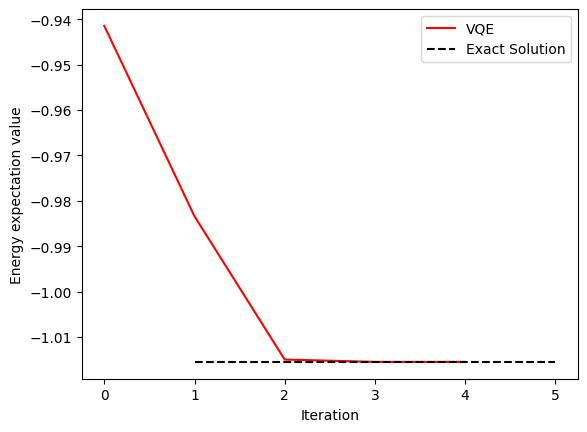

In [12]:
import PyPlot
PyPlot.plot(cost_history, color="red", label="VQE")
PyPlot.plot(1:length(cost_history), fill(molecule.fci_energy, length(cost_history)),
    linestyle="dashed", color="black", label="Exact Solution")
PyPlot.xlabel("Iteration")
PyPlot.ylabel("Energy expectation value")
PyPlot.legend()
PyPlot.show()

In [13]:
divide_real_imag_openfermion(op) = 
    (op+of.utils.hermitian_conjugated(op))/2, (op-of.utils.hermitian_conjugated(op))/2im

function make_rdm1(state, n_qubit)
    one_rdm = zeros(Complex{Float64}, n_qubit, n_qubit)
    for p in 1:n_qubit, q in 1:n_qubit
        jw_hamiltonian = jordan_wigner(of.ops.FermionOperator(((p-1, 1), (q-1, 0))))
        her, antiher = divide_real_imag_openfermion(jw_hamiltonian)
        qulacs_hamiltonian_real = convert_openfermion_op(n_qubit, her)
        qulacs_hamiltonian_imag = convert_openfermion_op(n_qubit, antiher)
        pq_one_rdm_real = qulacs_hamiltonian_real.get_expectation_value(state)
        pq_one_rdm_imag = qulacs_hamiltonian_imag.get_expectation_value(state)
        one_rdm[p, q] = pq_one_rdm_real + pq_one_rdm_imag * im
    end
    one_rdm
end

make_rdm1 (generic function with 1 method)

## 縮約密度行列の計算法
以下のコードブロックでは、VQE波動関数から１次の縮約密度行列
$$
\gamma_{pq} =
\langle \Psi |
a^{\dagger}_p a_q
|\Psi \rangle 
$$
を計算する方法を示す。

In [14]:
import LinearAlgebra

state = qulacs.QuantumState(n_qubit) 
state.set_computational_basis(hfstate(n_qubit, n_electron))# Hartree-Fock State
rdm_hf = make_rdm1(state, n_qubit)
println("RDM of HF")
println(rdm_hf)
println("Number of electrons (HF)")
println(real(LinearAlgebra.tr(rdm_hf)))

circuit.update_quantum_state(state) #量子回路を状態に作用
rdm_uccsd = make_rdm1(state, n_qubit)
println("RDM of UCCSD")
println(rdm_uccsd)
println("Number of electrons (UCCSD)")
println(real(LinearAlgebra.tr(rdm_hf)))    

RDM of HF
Complex{Float64}[1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im]
Number of electrons (HF)
2.0
RDM of UCCSD
Complex{Float64}[0.9008535337158332 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.9008535337158332 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.09914646628416685 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.09914646628416685 + 0.0im]
Number of electrons (UCCSD)
2.0
